Solving Poisson's equation with HHL
==============

**Implemented with  Qiskit **

**Author:** *Eddie Kelly*



*Recap*
Consider the problem below:
Let $$\Omega=[0,1]^{d}\subset \mathbb{R}^{d}$$ and $$v(x),b(x):\mathbb{R}^{d}\rightarrow \mathbb{R}$$  
We want to solve the problem $$ -\nabla^{2}v(x)=b(x),  x \in \Omega$$ 
with boundary condition given by : $$v(x)=0,  x \in \partial \Omega$$

As alluded to before this can be converted into a linear algebra problem:
$$ \begin{gather}
       \frac{1}{h^{2}}
       \begin{pmatrix}
          2 & -1 & \dots & 0 \\
          -1 & \ddots & \ddots & 0 \\
          \vdots & \ddots & \ddots & \ -1 \\
           0 & 0 & -1 & 2
       \end{pmatrix}
       \begin{pmatrix}
           v_{1}\\
           v_{2}\\
           \vdots\\
           v_{N-1}\\
       \end{pmatrix}
       =
       \begin{pmatrix}
           b_{1}\\
           b_{2}\\
           \vdots\\
           b_{N-1}\\
       \end{pmatrix}
    \end{gather}$$

***We first need to write code to describe the matrix***

In [120]:
import numpy as np

def tridiag(T,x,y,z,k1=-1, k2=0, k3=1):
    a = [x]*(T-abs(k1)); b = [y]*(T-abs(k2)); c = [z]*(T-abs(k3))
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)

This will produce a tridiagonal matrix of the above type of dimension N

In [123]:
A=tridiag(4,-1,2,-1)
print(A)

[[ 2 -1  0  0]
 [-1  2 -1  0]
 [ 0 -1  2 -1]
 [ 0  0 -1  2]]


We are going to focus on the case for a 4x4 matrix.
The second matrix we need to calculate classically is used to convert the stored eigenvalues 
in the circuit into angular rotation coefficients for controlled rotation.
i.e. $$D=diag[\theta_{0},\theta_{1},..,\theta_{2^{n}-1}]$$
where: $$ \theta_{j}=\frac{1}{2}arcsin(\frac{C}{\lambda_{j}}) $$

---

We first define the function $$f(x)=\frac{1}{2}arcsin(\frac{C}{x})$$

In [124]:
def f(x,C):
    return 0.5*np.arcsin(C/x)

We now define the matrix D as follows:

In [125]:
N=4
K=np.linalg.cond(A)
EIGENLIST=np.linalg.eigvals(A)
ANGLIST=[]
for j in range(0,N): 
    ANGLIST.append(f(EIGENLIST[j],1/K))
DIAGLIST=[]    
for i in range(0,N):
    DIAGLIST.append(np.exp(2*np.pi*1j*ANGLIST[i]))
diag=np.diag(DIAGLIST)

print(diag)

[[0.99580002+0.09155506j 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.99198179+0.12638092j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.6373294 +0.77059149j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.97128319+0.23792639j]]


---
We are almost ready to start building our quantum circuit! 
Our circuit will contain 7 qubits and 3 classical bits.



We intialize the vector with coefficients b1, b2 , b3 and b4.

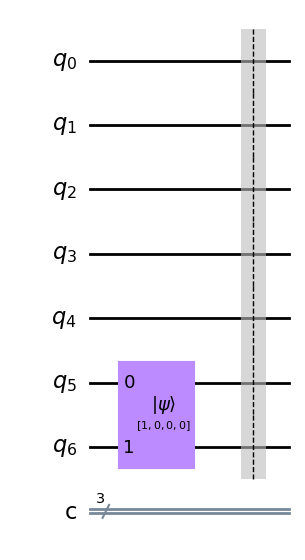

In [126]:
import qiskit 
from qiskit import *
from qiskit.opflow import I, X, Y
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram
from qiskit.extensions import UnitaryGate

qc=QuantumCircuit(7,3)
qr=qc.qregs[0]
b1=1
b2=0
b3=0
b4=0

    

desired_vector = [
    b1/ np.sqrt(b1**2+b2**2+b3**2+b4**2) * complex(1, 0),
    b2/ np.sqrt(b1**2+b2**2+b3**2+b4**2) * complex(1, 0) ,
    b3 / np.sqrt(b1**2+b2**2+b3**2+b4**2) * complex(1, 0) ,
    b4/ np.sqrt(b1**2+b2**2+b3**2+b4**2) * complex(1, 0),
]

qc.initialize(desired_vector, [qr[5],qr[6]])
qc.barrier()
qc.draw("mpl")

**Quantum Phase Estimation**

We now implement the first quantum phase estimation subroutine employed in the algorithm.
Quantum Phase Estimation is applied to qubits 3 through 6 with
$$U=e^{iAt};t=\frac{2\pi 2^{k}}{2^{n}}$$

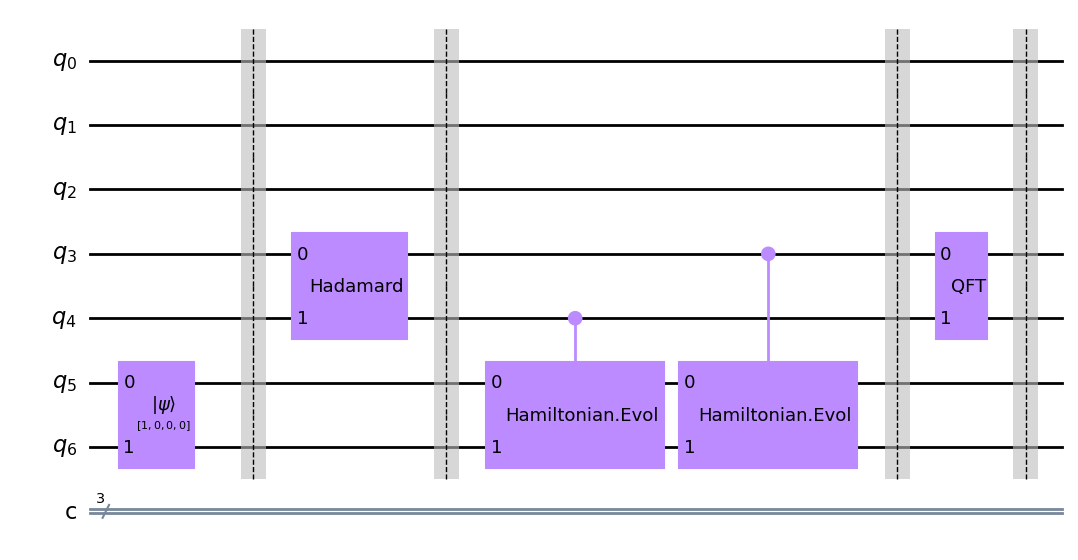

In [127]:
hada=QuantumCircuit(2,name='Hadamard')
hada.h(0)
hada.h(1)
hadagate=hada.to_gate()
qc.append(hada.to_instruction(),[qr[3],qr[4]])
qc.barrier()
####GATES 1 & 2 #####
from qiskit.circuit import QuantumCircuit
circuit=QuantumCircuit(2,name='Hamiltonian.Evol')

circuit.hamiltonian(A, time=-2*np.pi/(2**2), qubits=[0,1])
gate1=circuit.to_gate()
controlledgate1=gate1.control(1)

circuit.hamiltonian(A, time=-2*np.pi*2/(2**2), qubits=[0,1])
gate2=circuit.to_gate()
controlledgate2=gate2.control(1)

### inserting to main circuit###
qc.append(controlledgate1,[4,5,6])
qc.append(controlledgate2,[3,5,6])
################################

###Quantum Fourier Transform###
qft=QuantumCircuit(2,name='QFT')
qft.h(0)
qft.cp(np.pi/2,0,1)
qft.h(1)
qft.swap(0,1)



###inserting into main circuit###
qc.barrier()
qc.append(qft.to_instruction(),[3,4])
qc.barrier()
qc.draw("mpl")

The second QPE subroutine is implented. Quantum Phase Estimation is applied to qubits 1 through 4  with 
$$U=e^{iDt}; t=\frac{2\pi 2^{k}}{2^{n}}$$

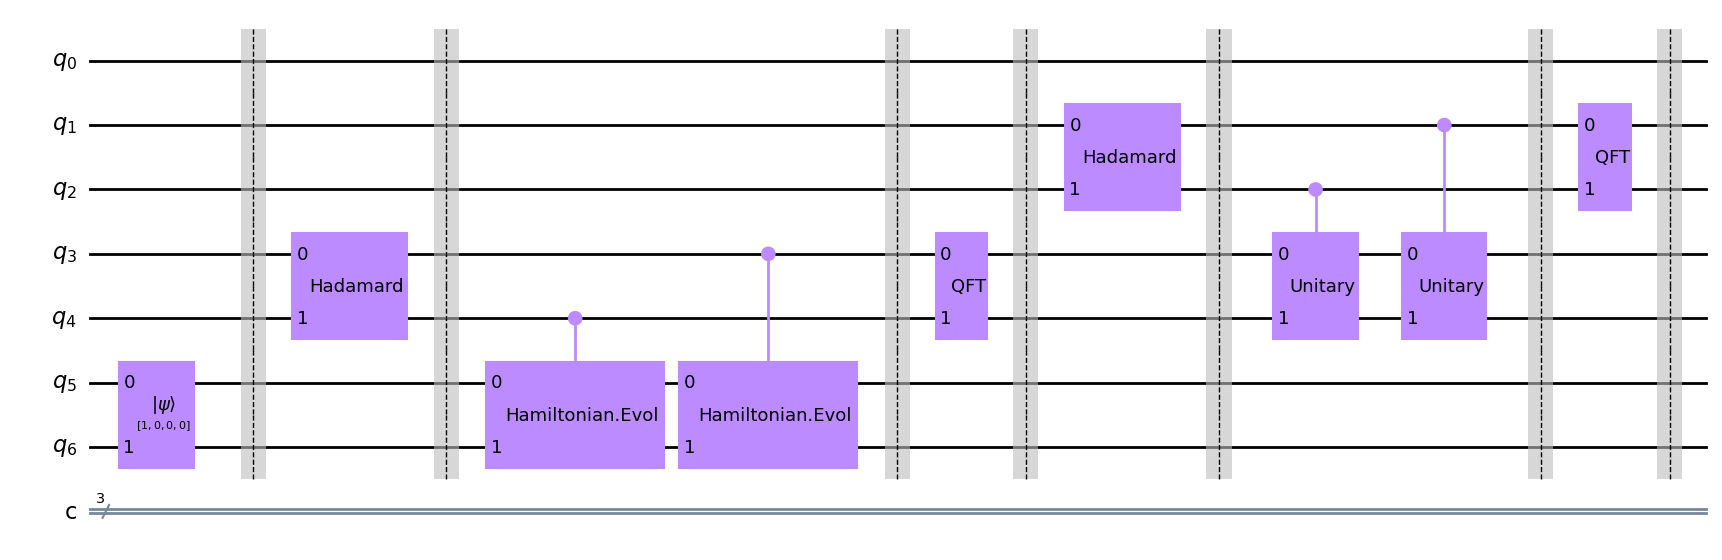

In [128]:
###Second QPE###
qc.append(hada.to_instruction(),[qr[1],qr[2]])
qc.barrier()

####GATE 3 & GATE 4 #####
circuit=QuantumCircuit(2,name='Hamiltonian.Evol')
diag2=np.matmul(diag,diag)
D= UnitaryGate(diag)
controlledD=D.control(1)
D2=UnitaryGate(diag2)
controlledD2=D2.control(1)

###inserting into main circuit###

qc.append(controlledD,[2,3,4])
qc.append(controlledD2,[1,3,4])
qc.barrier()
qc.append(qft.to_instruction(),[1,2])
qc.barrier()
qc.draw("mpl")

**Controlled RY rotations**

We now rotate the ancilla qubit

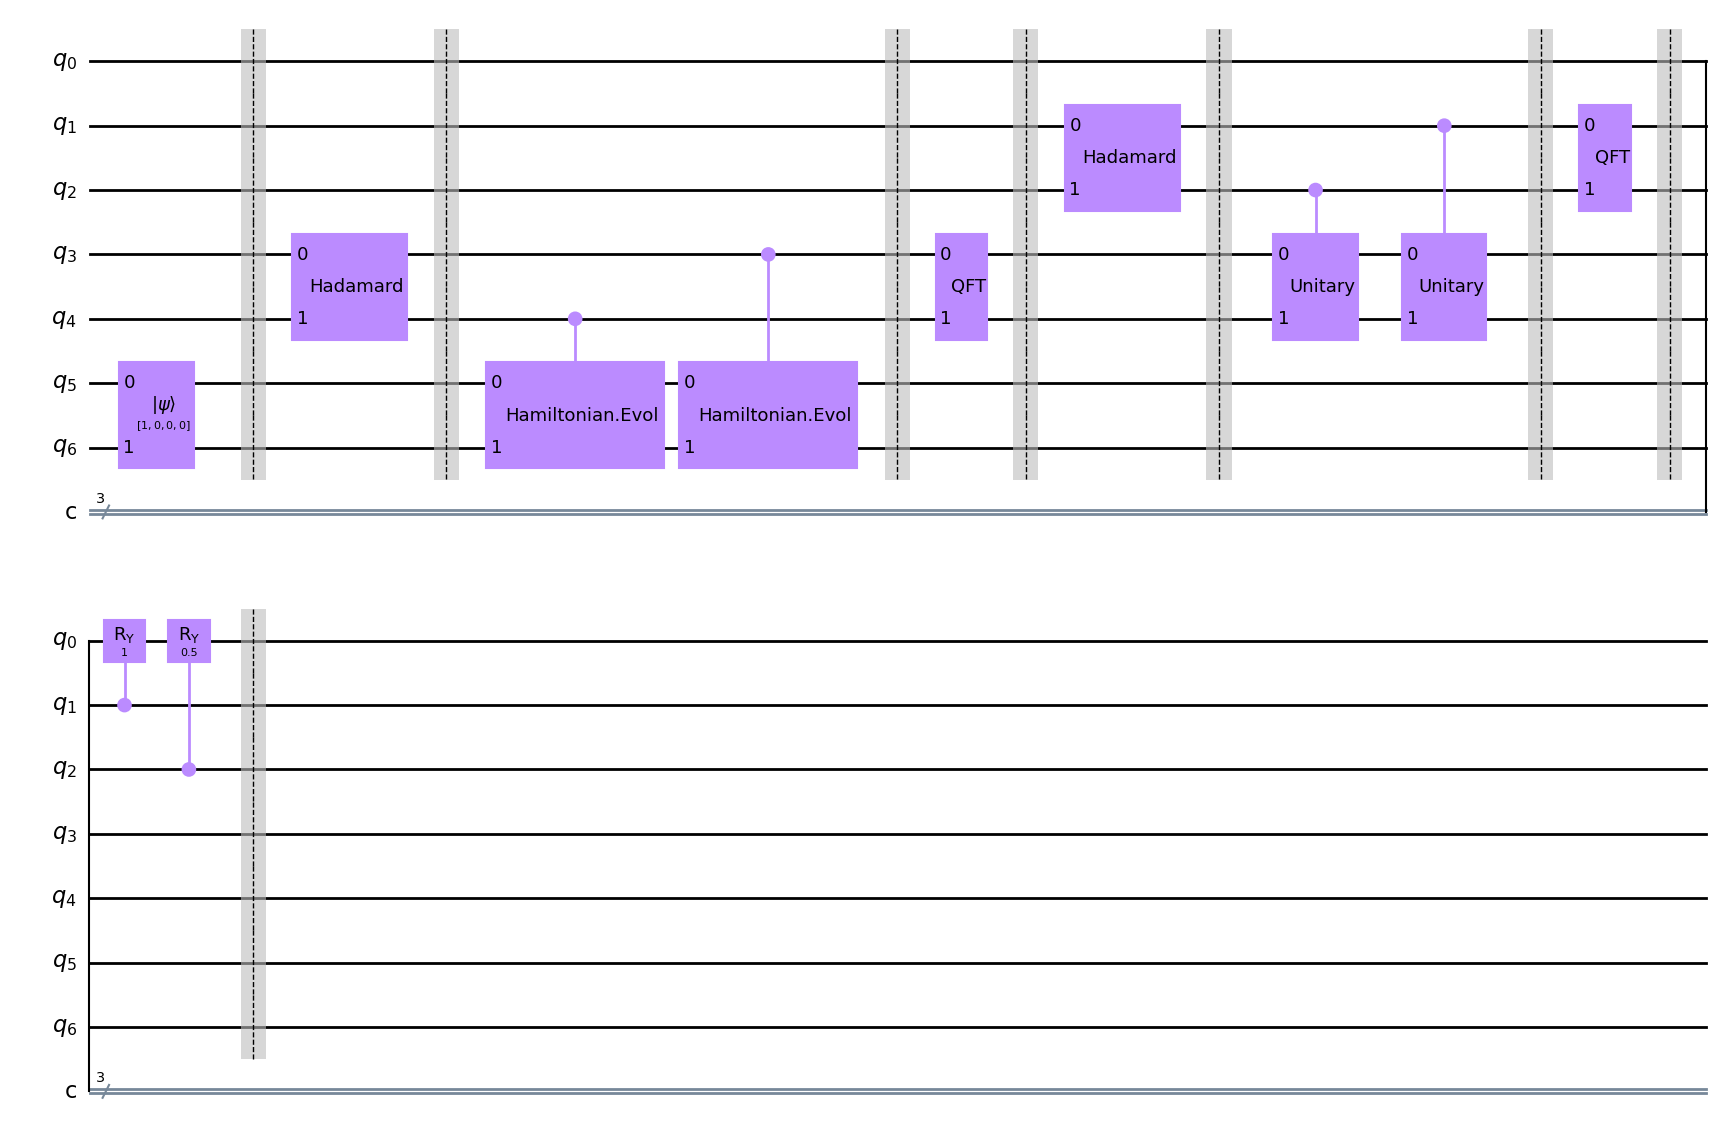

In [129]:
#####CONTROLLED Y ROTATION
qc.cry(1,1,0)
qc.cry(0.5,2,0)
qc.barrier()
qc.draw("mpl")

**Uncompute**

We now uncompute all previous operations:

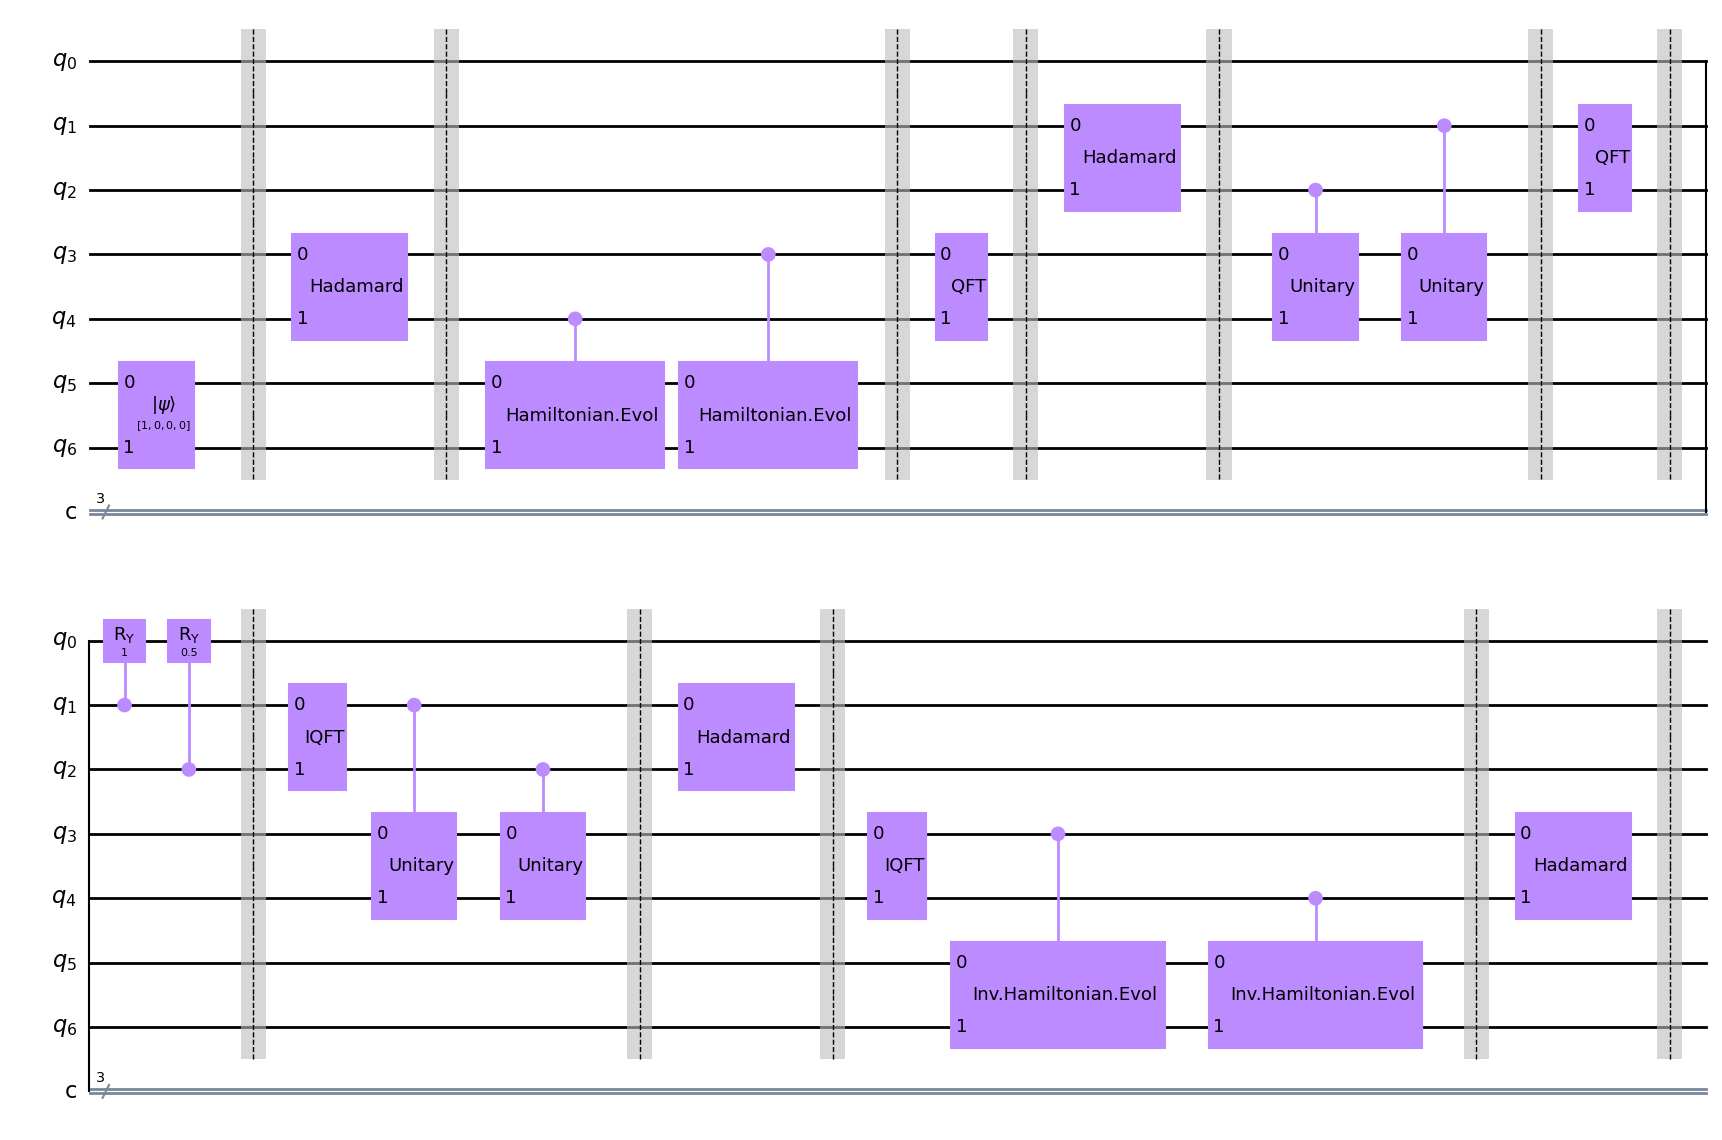

In [130]:
#UNCOMPUTATION#
### Inverse Quantum Fourier Transform###
iqft=QuantumCircuit(2,name='IQFT')
iqft.swap(0,1)
iqft.h(1)
iqft.cp(-np.pi/2,0,1)
iqft.h(0)


##inserting into circuit#######
qc.append(iqft,[1,2])
###############################


###INVERSE GATES 3&4 ##########
circuit=QuantumCircuit(2,name='Hamiltonian')
invD=UnitaryGate(diag).adjoint()
invD2=UnitaryGate(diag2).adjoint()
controlledinvD=invD.control(1)
controlledinvD2=invD2.control(1)

###inserting into circuit####
qc.append(controlledinvD2,[1,3,4])
qc.append(controlledinvD,[2,3,4])
qc.barrier()
qc.append(hada.to_instruction(),[qr[1],qr[2]])
qc.barrier()
qc.append(iqft,[3,4])
#############################


#####INVERSE GATES 2&1 #######
circuit=QuantumCircuit(2,name='Inv.Hamiltonian.Evol')
circuit.hamiltonian(A, time=2*np.pi/(2**2), qubits=[0,1])
gate1=circuit.to_gate()
controlledgate1=gate1.control(1)

circuit.hamiltonian(A, time=2*np.pi*2/(2**2), qubits=[0,1])
gate2=circuit.to_gate()
controlledgate2=gate2.control(1)

### inserting to main circuit###
qc.append(controlledgate2,[3,5,6])
qc.append(controlledgate1,[4,5,6])
qc.barrier()
qc.append(hada.to_instruction(),[qr[3],qr[4]])
qc.barrier()
qc.draw("mpl")

**Postselection and Measurement**

We first measure the ancilla qubit 0. If the state 1 is measured,

the solution to the quantum linear systems will be stored in the register formed by qubits 5 and 6.

We then measure qubits 5 , 6 to compare the quantum state to the actual solution

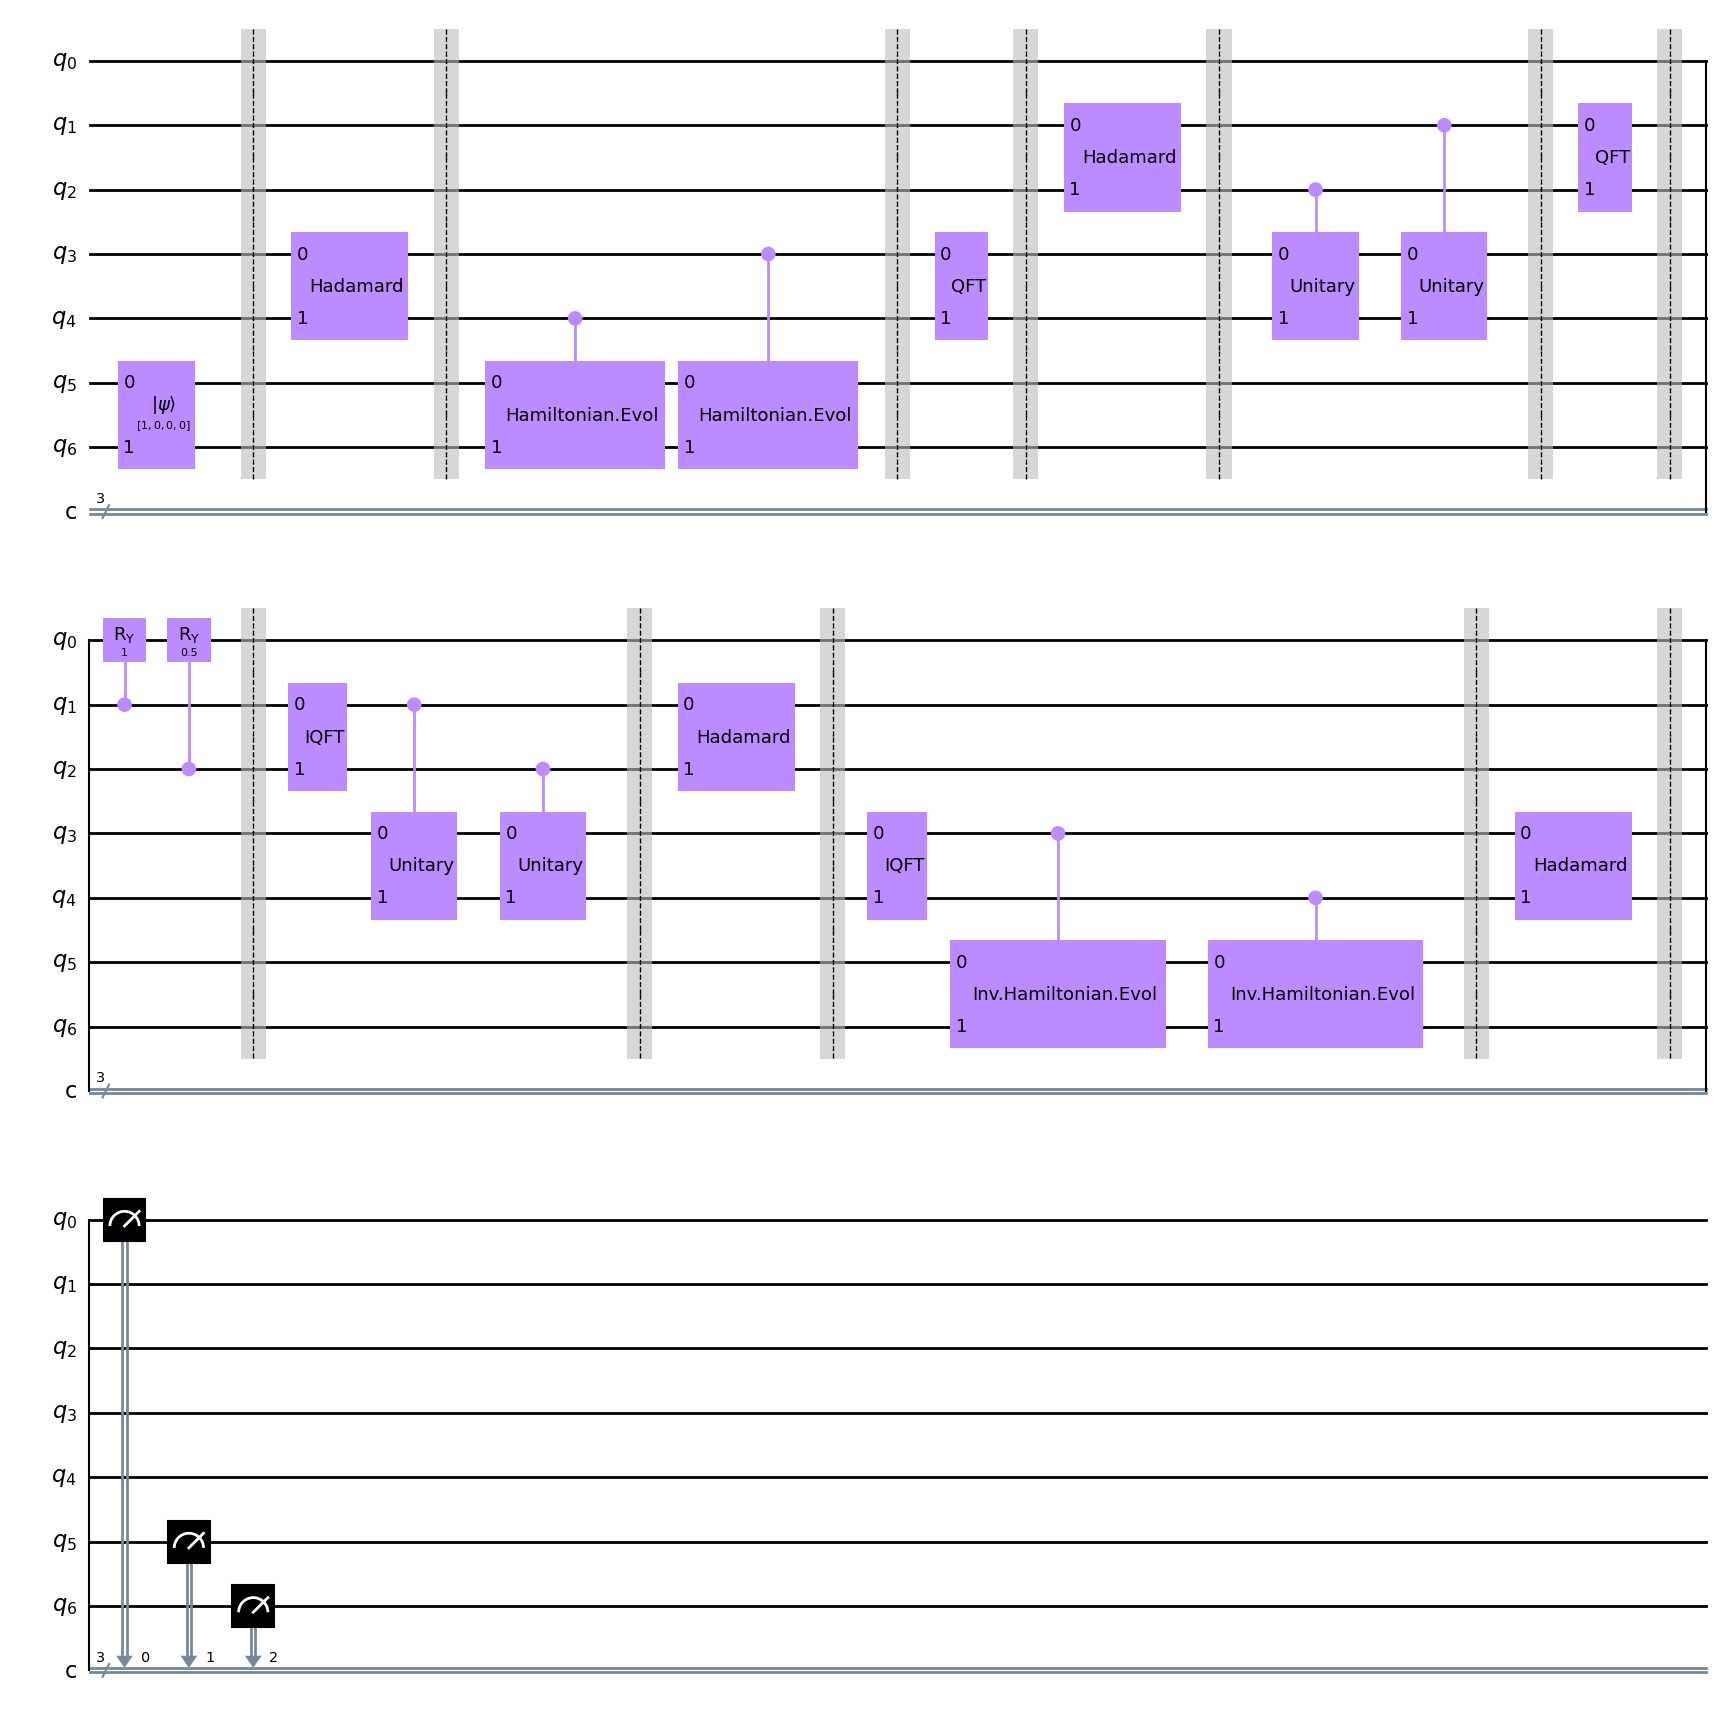

In [131]:
##Measurement##
qc.measure(0,0)
qc.measure(5,1)
qc.measure(6,2)
qc.draw("mpl")

Numerical Results
-----------------


We use the Qiskit QASM simulator backend to run the circuit. We simulate the circuit 50000 times.

The normalized input vector = [(1+0j), 0j, 0j, 0j]

The normalized quantum state solution = [0.65589866 0.65783061 0.34354083 0.13796932]

The classically solved solution normalized = [0.73029674+0.j 0.54772256+0.j 0.36514837+0.j 0.18257419+0.j]

Fidelity = 0.9799858172370839


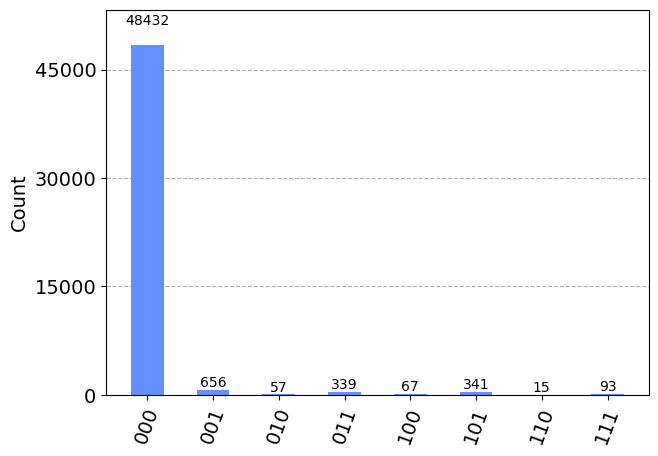

In [132]:
from colorama import Fore, Back, Style
backend_sim = Aer.get_backend('qasm_simulator')




Number_of_shots=50000

job_sim = backend_sim.run(transpile(qc, backend_sim), shots=Number_of_shots)
result_sim = job_sim.result()
counts=result_sim.get_counts()
numbers=list(counts.values())
relnumbers=[varx[1] for varx in enumerate(numbers) if varx[0] in [1,3,5,7]]
relnumbers=np.array(relnumbers)
fnumbers=np.sqrt(relnumbers/sum(relnumbers))
print("The normalized input vector =",desired_vector)
print()
print("The normalized quantum state solution =",fnumbers)
################comparing to actual answer#########################
Vec1=np.linalg.solve(A,desired_vector)
norm=np.linalg.norm(Vec1)
Vec1=Vec1/norm
print()
print("The classically solved solution normalized =",Vec1)
print()
print(Back.GREEN+"Fidelity =", np.abs(np.dot(Vec1,fnumbers))**2)

plot_histogram(counts)


 As we can see, fidelity is roughly >0.9 


------------

Second Poisson Solver
---------------------
---------------------

Consider the angular rotation coefficients  $$ \theta_{j}=\frac{1}{2}arcsin(\frac{C}{\lambda_{j}})$$

which was derived from the function $$f(x)=\frac{1}{2}arcsin(\frac{C}{x})$$

Consider the case whereby the matrix of interest A has large eigenvalues $$\frac{C}{\lambda_{j}}<<1 $$

The taylor expansion of arcsin(x) is given by:$$arcsin(x)=x+\mathcal{O}(x^{3})$$
    
*Therefore:$$\theta_{j}\approx\frac{C}{2\lambda_{j}}<<1$$*
    
$$As D=diag[\theta_{0},\theta_{1},..,\theta_{2^{n}-1}]$$

$$\rightarrow U=e^{iDt}\approx \mathbf{I}$$

 ---------

This means we can omit the second phase estimation subroutine in HHL
We present the code below:

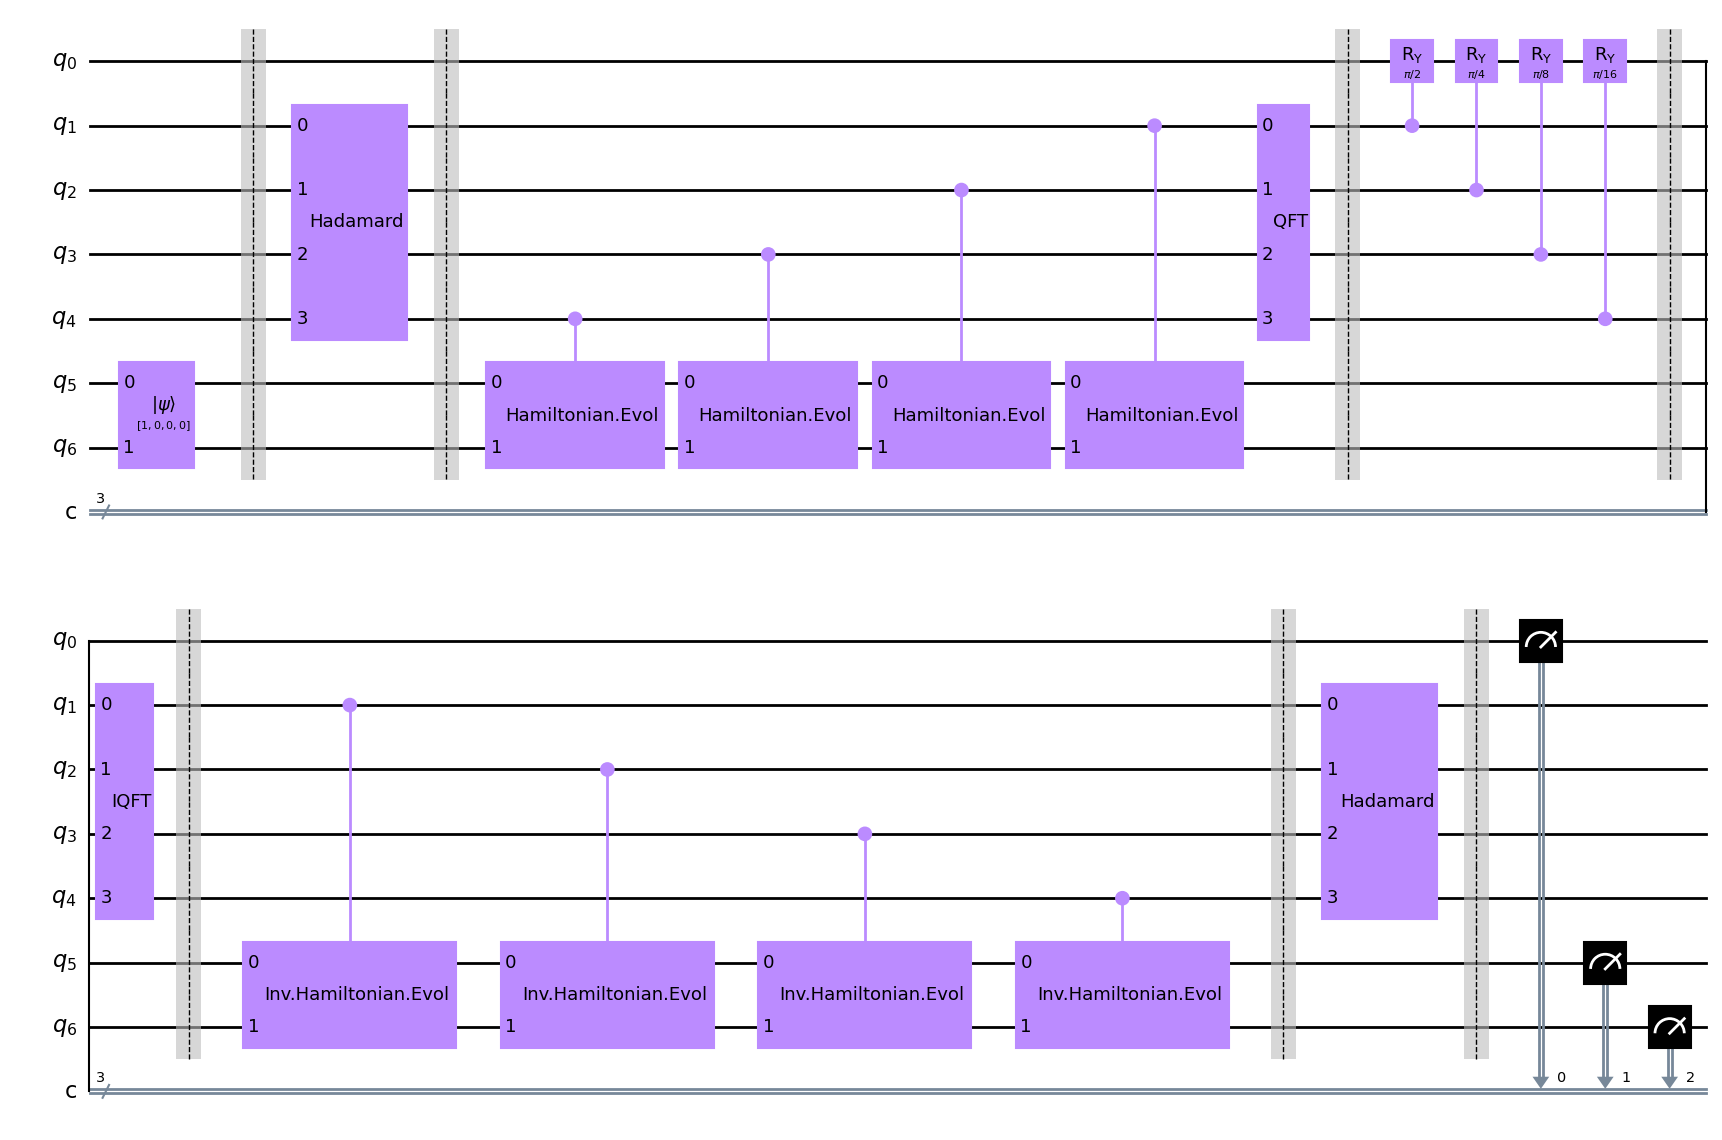

In [133]:
import qiskit 
from qiskit import *
import numpy as np
from qiskit.compiler import transpile


Number_of_wires=4
qc=QuantumCircuit(7,3)
qr=qc.qregs[0]
#####VARIABLES#######
N=4
b1=1
b2=0
b3=0
b4=0



#####Controlled rotation functions########
def f(x,C):
    return 0.5*np.arcsin(C/x)

############ matrix creation#############################
def tridiag(T,x,y,z,k1=-1, k2=0, k3=1):
    a = [x]*(T-abs(k1)); b = [y]*(T-abs(k2)); c = [z]*(T-abs(k3))
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
A=tridiag(N,-1,3,-1)
###########################################################
###########################################################
###########################################################
desired_vector = [
    b1/ np.sqrt(b1**2+b2**2+b3**2+b4**2) * complex(1, 0),
    b2/ np.sqrt(b1**2+b2**2+b3**2+b4**2) * complex(1, 0) ,
    b3 / np.sqrt(b1**2+b2**2+b3**2+b4**2) * complex(1, 0) ,
    b4/ np.sqrt(b1**2+b2**2+b3**2+b4**2) * complex(1, 0),
]
qc.initialize(desired_vector, [5,6])
qc.barrier()



hada=QuantumCircuit(4,name='Hadamard')
hada.h(0)
hada.h(1)
hada.h(2)
hada.h(3)
hadagate=hada.to_gate()
qc.append(hada.to_instruction(),[1,2,3,4])
qc.barrier()

####GATES 1 & 2 #####
circuit=QuantumCircuit(2,name='Hamiltonian.Evol')

circuit.hamiltonian(A, time=-2*np.pi/(2**4), qubits=[0,1])
gate1=circuit.to_gate()
controlledgate1=gate1.control(1)

circuit.hamiltonian(A, time=-2*np.pi*2/(2**4), qubits=[0,1])
gate2=circuit.to_gate()
controlledgate2=gate2.control(1)

circuit.hamiltonian(A, time=-2*np.pi*4/(2**4), qubits=[0,1])
gate3=circuit.to_gate()
controlledgate3=gate3.control(1)

circuit.hamiltonian(A, time=-2*np.pi*8/(2**4), qubits=[0,1])
gate4=circuit.to_gate()
controlledgate4=gate4.control(1)

### inserting to main circuit###
qc.append(controlledgate1,[4,5,6])
qc.append(controlledgate2,[3,5,6])
qc.append(controlledgate3,[2,5,6])
qc.append(controlledgate4,[1,5,6])
################################

###Quantum Fourier Transform###

circ=QuantumCircuit(Number_of_wires,name='QFT')
for i in range(0,Number_of_wires):
   circ.h(i)
   for j in range(2,i):
       circ.cp(2*np.pi/(2**j),i,j)
circ.swap(0,3)
circ.swap(1,2)
      

qftcirc=circ.to_instruction
qc.append(qftcirc(),[qr[1],qr[2],qr[3],qr[4]])
qc.barrier()
qc.cry(8*np.pi/2**4,1,0)
qc.cry(4*np.pi/2**4,2,0)
qc.cry(2*np.pi/2**4,3,0)
qc.cry(1*np.pi/2**4,4,0)
qc.barrier()
#####IQFT#####################
circ=QuantumCircuit(Number_of_wires,name='IQFT')
circ.swap(0,3)
circ.swap(1,2)
for i in reversed(range(0,Number_of_wires)):
   circ.h(i)
   for j in reversed(range(2,i)):
       circ.cp(-2*np.pi/(2**j),i,j)
iqftcirc=circ.to_instruction
qc.append(iqftcirc(),[1,2,3,4])
qc.barrier()
#####INVERSE GATES 2&1 #######
circuit=QuantumCircuit(2,name='Inv.Hamiltonian.Evol')

circuit.hamiltonian(A , time=2*np.pi*8/(2**4), qubits=[0,1])
gate1=circuit.to_gate()
controlledgate1=gate1.control(1)

circuit.hamiltonian(A, time=2*np.pi*4/(2**4), qubits=[0,1])
gate2=circuit.to_gate()
controlledgate2=gate2.control(1)

circuit.hamiltonian(A, time=2*np.pi*2/(2**4), qubits=[0,1])
gate3=circuit.to_gate()
controlledgate3=gate3.control(1)

circuit.hamiltonian(A, time=2*np.pi*1/(2**4), qubits=[0,1])
gate4=circuit.to_gate()
controlledgate4=gate4.control(1)

### inserting to main circuit###
qc.append(controlledgate4,[1,5,6])
qc.append(controlledgate3,[2,5,6])
qc.append(controlledgate2,[3,5,6])
qc.append(controlledgate1,[4,5,6])
qc.barrier()
qc.append(hada.to_instruction(),[1,2,3,4])
qc.barrier()
qc.measure(0,0)
qc.measure(5,1)
qc.measure(6,2)
qc.draw("mpl")

Numerical Results
-----------------

We use the Qiskit QASM simulator backend to run the circuit. We simulate the circuit 50000 times.

The normalized input vector= [(1+0j), 0j, 0j, 0j]

The normalized quantum state solution= [0.43811881 0.65365037 0.46437527 0.40638492]

The classically solved solution normalized= [0.92537056+0.j 0.35252212+0.j 0.13219579+0.j 0.04406526+0.j]

Fidelity= 0.511431489299501


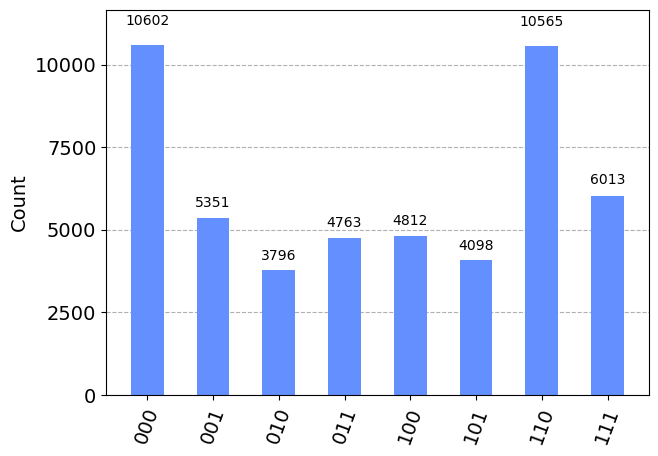

In [136]:
###############################
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
###############################
backend_sim = Aer.get_backend('qasm_simulator')

Number_of_shots=50000
job_sim = backend_sim.run(transpile(qc, backend_sim), shots=Number_of_shots)
result_sim = job_sim.result()
counts=result_sim.get_counts()
numbers=list(counts.values())
relnumbers=[varx[1] for varx in enumerate(numbers) if varx[0] in [1,3,5,7]]
relnumbers=np.array(relnumbers)
fnumbers=np.sqrt(relnumbers/sum(relnumbers))
print("The normalized input vector=",desired_vector)
print()
print("The normalized quantum state solution=",fnumbers)
################comparing to actual answer#########################
Vec1=np.linalg.solve(A,desired_vector)
norm=np.linalg.norm(Vec1)
Vec1=Vec1/norm
print()
print("The classically solved solution normalized=",Vec1)
print()
print(Back.GREEN+"Fidelity=",np.abs(np.dot(Vec1,fnumbers))**2)
plot_histogram(counts)

As you can see the fidelity is less in this implementation $$\approx 0.6$$ even though 
we have addition registers to store the eigenvalues to a higher accuracy.

In this instance the error from the approximation of the arcsin function is dominant
over the reduced error in the larger number of clock qubits.

**Condition Number**

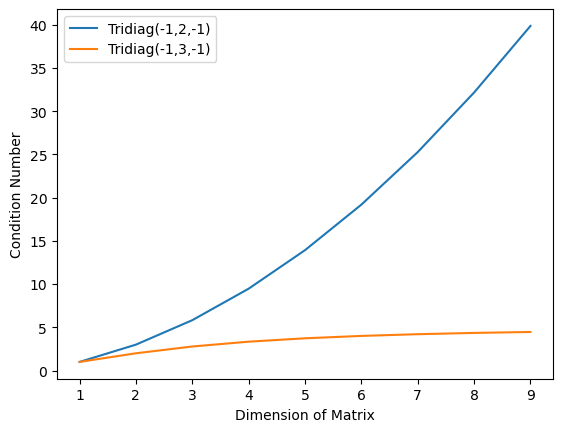

In [137]:
import matplotlib.pyplot as plt
Xlist=np.arange(1,10,1)
Ylist=[]
Zlist=[]
for i in Xlist:
    Ylist.append(np.linalg.cond(tridiag(i,-1,2,-1)))
    Zlist.append(np.linalg.cond(tridiag(i,-1,3,-1)))
plt.plot(Xlist,Ylist,label='Tridiag(-1,2,-1)')  
plt.plot(Xlist,Zlist,label='Tridiag(-1,3,-1)')
plt.xlabel('Dimension of Matrix')
plt.ylabel('Condition Number')
plt.legend()